<a href="https://colab.research.google.com/github/Safat99/emergency_vehicle_detection/blob/main/vgg19_approach/emergency_car_detection_with_vgg_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%cd /content/drive/MyDrive/vgg19_approach

/content/drive/MyDrive/vgg19_approach


In [6]:
from sklearn.utils import shuffle
import config
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from imutils import paths
import numpy as np
import os
import pandas as pd
import pickle


In [7]:

data = [] #images
labels = []
bboxes = []
filenames = []
imagePaths = []


In [8]:
cars = pd.read_csv(os.path.join(config.base_path,'images', 'train_test_vgg_format.csv'))

In [10]:
for i in cars.IMAGE:
	image = load_img(os.path.join(config.images_path, str(i) + ".jpg"))
	image = img_to_array(image)
	
	data.append(image)
	imagePaths.append(os.path.join(config.images_path, str(i) + ".jpg"))

tmp = []

for i in range(len(cars)):
	for j in range(1,5):
		tmp.append(cars.iloc[i,j])

	labels.append(cars.CLASS[i])
	bboxes.append(tmp)
	tmp = []


In [11]:
# convert the data and labels to NumPy arrays, scaling the input
# pixel intensities from the range [0, 255] to [0, 1]
data = np.array(data, dtype="float32") / 255.0
labels = np.array(labels)
bboxes = np.array(bboxes, dtype='float32')
imagePaths = np.array(imagePaths)


In [12]:

lb = LabelBinarizer()
labels = lb.fit_transform(labels)

if len(lb.classes_) == 2:
	labels = to_categorical(labels)


In [13]:

# partition the data into training and testing splits using 90% of
# the data for training and the remaining 10% for testing
train_images,test_images,trainLabels,testLabels,trainBboxes, testBboxes, trainPaths, testPaths = train_test_split(data, labels, bboxes, imagePaths, test_size=0.20,
	random_state=42, shuffle = True)

# write the testing filenames to disk so that we can use then
# when evaluating/testing our bounding box regressor
print("[INFO] saving testing filenames...")
f = open(config.test_path, "w")
f.write("\n".join('testPaths'))
f.close()



[INFO] saving testing filenames...


In [14]:
############################################333             VGG19 (same as vgg16) #####################


vgg = VGG19(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# freeze all VGG layers so they will *not* be updated during the
# training process
vgg.trainable = False

# flatten the max-pooling output of VGG
flatten = vgg.output
flatten = Flatten()(flatten)

# construct a fully-connected layer header to output the predicted
# bounding box coordinates
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid",
	name="bounding_box")(bboxHead)
# construct a second fully-connected layer head, this one to predict
# the class label
softmaxHead = Dense(512, activation="relu")(flatten)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(512, activation="relu")(softmaxHead)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(len(lb.classes_), activation="softmax",
	name="class_label")(softmaxHead)
# put together our model which accept an input image and then output
# bounding box coordinates and a class label
model = Model(
	inputs=vgg.input,
	outputs=(bboxHead, softmaxHead))



80142336/80134624 [==============================] - 1s 0us/step


In [15]:
# define a dictionary to set the loss methods -- categorical
# cross-entropy for the class label head and mean absolute error
# for the bounding box head
losses = {
	"class_label": "categorical_crossentropy",
	"bounding_box": "mean_squared_error",
}
# define a dictionary that specifies the weights per loss (both the
# class label and bounding box outputs will receive equal weight)
lossWeights = {
	"class_label": 1.0,
	"bounding_box": 1.0
}
# initialize the optimizer, compile the model, and show the model
# summary
opt = Adam(lr=config.INIT_LR)
model.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=lossWeights)
print(model.summary())

# construct a dictionary for our target training outputs
trainTargets = {
	"class_label": trainLabels,
	"bounding_box": trainBboxes
}
# construct a second dictionary, this one for our target testing
# outputs
testTargets = {
	"class_label": testLabels,
	"bounding_box": testBboxes
}


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
______________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
config.NUM_EPOCHS = 250

In [ ]:
config.model_path

'/content/drive/My Drive/vgg19_approach/outputs_vgg19/detector_vgg19.h5'

In [ ]:
# train the network for bounding box regression and class label
# prediction
print("[INFO] training model...")
H = model.fit(
	train_images, trainTargets,
	validation_data=(test_images, testTargets),
	batch_size=config.BATCH_SIZE,
	epochs=config.NUM_EPOCHS,
	verbose=1)
# serialize the model to disk
print("[INFO] saving object detector model...")
model.save(config.model_path, save_format="h5")


print('[INFO] saving training history in history_vgg19 file')
f = open('training_history_vgg19' , 'wb')
pickle.dump(H.history, f)
f.close()

# serialize the label binarizer to disk
print("[INFO] saving label binarizer...")
f = open(config.lb_PATH, "wb")
f.write(pickle.dumps(lb))
f.close()


[INFO] training model...
Epoch 1/250
58/58 [==============================] - 52s 261ms/step - loss: 0.6949 - bounding_box_loss: 0.0159 - class_label_loss: 0.6790 - bounding_box_accuracy: 0.6487 - class_label_accuracy: 0.6864 - val_loss: 0.4793 - val_bounding_box_loss: 0.0075 - val_class_label_loss: 0.4718 - val_bounding_box_accuracy: 0.7699 - val_class_label_accuracy: 0.7570
Epoch 2/250
58/58 [==============================] - 11s 197ms/step - loss: 0.4964 - bounding_box_loss: 0.0048 - class_label_loss: 0.4916 - bounding_box_accuracy: 0.7398 - class_label_accuracy: 0.7554 - val_loss: 0.4313 - val_bounding_box_loss: 0.0061 - val_class_label_loss: 0.4253 - val_bounding_box_accuracy: 0.7720 - val_class_label_accuracy: 0.7699
Epoch 3/250
58/58 [==============================] - 12s 201ms/step - loss: 0.4302 - bounding_box_loss: 0.0037 - class_label_loss: 0.4265 - bounding_box_accuracy: 0.7856 - class_label_accuracy: 0.7953 - val_loss: 0.4130 - val_bounding_box_loss: 0.0055 - val_class_lab

In [ ]:
############################################### training close >>> accuracy and loss calculation ###########


'''naking a plot for visualizing total loss, class label loss , bounding box regression loss
'''
# plot the total loss, label loss, and bounding box loss
lossNames = ["loss", "class_label_loss", "bounding_box_loss"]
N = np.arange(0, config.NUM_EPOCHS)
plt.style.use("ggplot")
(fig, ax) = plt.subplots(3, 1, figsize=(13, 13))
# loop over the loss names
for (i, l) in enumerate(lossNames):
	# plot the loss for both the training and validation data
	title = "Loss for {}".format(l) if l != "loss" else "Total loss"
	ax[i].set_title(title)
	ax[i].set_xlabel("Epoch #")
	ax[i].set_ylabel("Loss")
	ax[i].plot(N, H.history[l], label=l)
	ax[i].plot(N, H.history["val_" + l], label="val_" + l)
	ax[i].legend()
# save the losses figure and create a new figure for the accuracies
plt.tight_layout()
plotPath = os.path.sep.join([config.PLOTS_PATH, "losses.png"])
plt.savefig(plotPath)
plt.close()


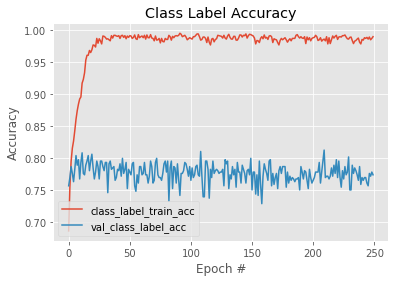

In [ ]:
############			Accuracy 			#############33

#The final step is to plot our training and validation accuracy:

# create a new figure for the accuracies
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["class_label_accuracy"],
	label="class_label_train_acc")
plt.plot(N, H.history["val_class_label_accuracy"],
	label="val_class_label_acc")
plt.title("Class Label Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
# save the accuracies plot
plotPath = os.path.sep.join([config.PLOTS_PATH, "accs.png"])
plt.savefig(plotPath)


In [16]:
import IPython
display(IPython.display.Audio(url="https://ssl.gstatic.com/dictionary/static/sounds/20180430/complete--_us_1.mp3", autoplay=True))

#accuracy

## Load model again from the Cloud

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# for **25** epochs

In [17]:
from tensorflow import keras
model = keras.models.load_model('//content/drive/MyDrive/vgg19_approach/25_epoch_results/detector_vgg19.h5')


In [18]:
loss,bbx_loss, class_label_loss, bbx_accu, class_label_accu = model.evaluate(test_images, testTargets, verbose = 1)
print("Accuracy for class label on test set is : {}". format(class_label_accu))
print("Accuracy for bounding_box on test set is :{}".format(bbx_accu))

15/15 [==============================] - 41s 411ms/step - loss: 0.7311 - bounding_box_loss: 0.0050 - class_label_loss: 0.7261 - bounding_box_accuracy: 0.8194 - class_label_accuracy: 0.7914
Accuracy for class label on test set is : 0.7913978695869446
Accuracy for bounding_box on test set is :0.8193548321723938


#for 100 epochs

In [19]:
model = keras.models.load_model('/content/drive/MyDrive/vgg19_approach/100_epoch_result/detector_vgg19.h5')

In [20]:
loss,bbx_loss, class_label_loss, bbx_accu, class_label_accu = model.evaluate(test_images, testTargets, verbose = 1)
print("Accuracy for class label on test set is : {}". format(class_label_accu))
print("Accuracy for bounding_box on test set is :{}".format(bbx_accu))

15/15 [==============================] - 3s 150ms/step - loss: 1.0324 - bounding_box_loss: 0.0050 - class_label_loss: 1.0274 - bounding_box_accuracy: 0.8194 - class_label_accuracy: 0.7613
Accuracy for class label on test set is : 0.7612903118133545
Accuracy for bounding_box on test set is :0.8193548321723938


# for 250 epochs

In [21]:
model = keras.models.load_model('/content/drive/MyDrive/vgg19_approach/250_epoches_result/detector_vgg19.h5')

In [22]:
loss,bbx_loss, class_label_loss, bbx_accu, class_label_accu = model.evaluate(test_images, testTargets, verbose = 1)
print("Accuracy for class label on test set is : {}". format(class_label_accu))
print("Accuracy for bounding_box on test set is :{}".format(bbx_accu))

15/15 [==============================] - 3s 150ms/step - loss: 1.6396 - bounding_box_loss: 0.0048 - class_label_loss: 1.6348 - bounding_box_accuracy: 0.8280 - class_label_accuracy: 0.7742
Accuracy for class label on test set is : 0.774193525314331
Accuracy for bounding_box on test set is :0.8279569745063782
